# Q0) Explain whether the data below are sequential or not.

- Time-Series Stock Data
- Strategy for Super Mario Brothers game
- Video Data
- Image Data such as MNIST Data

*Your Answer:*
1. Time-Series Stock Data => 0
2. Strategy for Super Mario Brothers game => 0
3. Video Data => 0
4. Image Data such as MNIST Data => 0

In [ ]:
import numpy as np

# RNN

아래 RNN class는 한 개의 시점에서 RNN이 작동하는 방식을 구현해놓은 것입니다. 강의 내용과 아래 그림을 참고하여 빈칸에 알맞은 답을 채워넣어보세요.


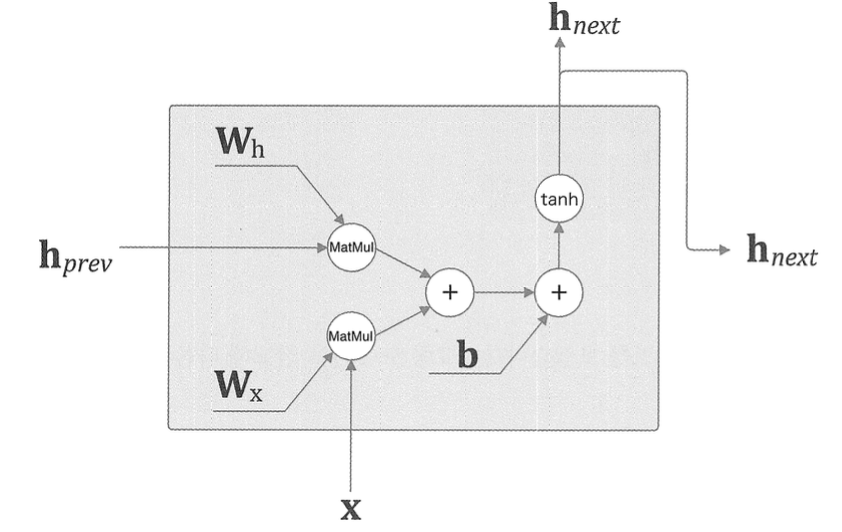


In [ ]:
class RNN:

    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None


    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        """
        문제 1: hidden state를 update할 때 행렬곱 연산을 한 후 더하는 과정에서 "이것"을 같이 더해줍니다.
        "이것"에 해당하는 것을 채워넣어주세요.
        """
        t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
        """
        문제 2: hidden state의 activation function은 무엇일까요? 다음 cell로 넘기기 위해 "빈칸"에 들어갈 적절한 값을 채워넣어주세요.
        """
        h_next = np.tanh(t)


    def backward(self, dh_next):
        Wx, Wh, b = self.params
        """
        문제 3: Backpropagation 과정에 필요한 아래 parameter들은 어디에서 불러와야 할까요?
        """
        x, h_prev, h_next = self.cache
        dt = dh_next * (1 - h_next ** 2)  # dtanh
        db = np.sum(dt, axis=0)
        """
        문제 4: 가중치 행렬 Wh의 gradient인 dWh는 전치행렬과 미분된 행렬의 행렬곱 형태로 표현됩니다.
        matmul() 함수에 적절한 값을 넣어주세요.
        """
        dWh = np.matmul(h_prev.T, dt)
        dh_prev = np.matmul(dt, Wh.T)
        dWx = np.matmul(x.T, dt)
        dx = np.matmul(dt, Wx.T)
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        return dx, dh_prev

## TIME RNN
이번에는 한 시점에서만이 아닌, T개의 time step이 주어졌을 때의 RNN layer를 살펴보도록 합시다.

"밑바닥부터 시작하는 딥러닝" 216p를 참고하세요!

In [ ]:
class TimeRNN:

    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None  # 여러 time steps의 RNN cell을 리스트로 저장

        self.h = None  # forward() 진행 시 마지막 RNN cell의 hidden state
        self.dh = None  # backward() 진행 시 하나 앞 블록의 hidden state의 gradient. dh_next
        # True: hidden state를 유지한다. 아무리 긴 시계열 데이터라도 순전파를 끊지 않고 전파한다.
        # False: hidden state를 영행렬로 초기화
        self.stateful = stateful


    # hidden state(h)를 설정하는 메서드
    def set_state(self, h):
        self.h = h


    # hidden state(h)를 초기화하는 메서드
    def reset_state(self):
        self.h = None


    # input으로 받는 xs : T개 분량의 시계열 데이터
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape  # N(batch_size), T(time steps), D(input size. 입력 벡터의 차원 수)
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:  # stateful=False or 처음 호출 시
            self.h = np.zeros((N, H), dtype='f')  # hidden state가 영행렬로 초기화됨

        for t in range(T):
            # 앞서 구성한 RNN class를 갖고옴
            # *self.params: self.params 리스트의 원소인 Wx, Wh, b를 추출해 RNN 클래스의 __init__() 메서드에 전달
            layer = RNN(*self.params)
            """
            문제 5: 이 반복문은 각 time step별로 RNN의 forward 메서드를 실행하고 있습니다.
            그렇다면 input으로 들어갈 xs의 2번째 차원은 무엇이 되어야 할까요?
            """
            self.h = layer.forward(xs[:, t, :], self.h)

            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs


    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)  # 합산된 기울기 = dh_t + dh_next
            dxs[:, t, :] = dx
            # 최종 가중치의 기울기 = 각 RNN 계층의 가중치 기울기의 합
            # RNN 계층들이 똑같은 가중치를 사용하기 때문
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

## Quiz 6)모델에 대한 설명이 다음과 같을 때, 총 파라미터 개수를 구해보세요.

1. Embedding을 사용하며, 단어 집합(Vocabulary)의 크기가 5,000이고 임베딩 벡터의 차원은 100입니다.

2. 은닉층에서는 Simple RNN을 사용하며, 은닉 상태의 크기는 128입니다.

3. 훈련에 사용하는 모든 샘플의 길이는 30으로 가정합니다.

4. 이진 분류를 수행하는 모델로, 출력층의 뉴런은 1개로 시그모이드 함수를 사용합니다.

5. 은닉층은 1개입니다.

In [ ]:
import torch
import torch.nn as nn

class SimpleRNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, output_size):
        super(SimpleRNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_units, batch_first=True)
        self.fc = nn.Linear(hidden_units, output_size)

    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(1, x.size(0), self.rnn.hidden_size).to(x.device)  # 초기 은닉 상태
        out, _ = self.rnn(x, h0)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# 하이퍼파라미터 설정
vocab_size = 5000
embedding_dim = 100
hidden_units = 128
output_size = 1

# 모델 초기화
model = SimpleRNNModel(vocab_size, embedding_dim, hidden_units, output_size)

# 각 층의 파라미터 개수 출력
print("Model's parameter:")
total_params = 0
for param_tensor in model.state_dict():
    param_size = model.state_dict()[param_tensor].size()
    num_params = torch.prod(torch.tensor(param_size)).item()
    total_params += num_params
    print(f"{param_tensor}\t{param_size}\t=> Number of parameters: {num_params}")

# 총 파라미터 개수 출력
print(f'Total number of parameters: {total_params}')

Model's parameter:
embedding.weight	torch.Size([5000, 100])	=> Number of parameters: 500000
rnn.weight_ih_l0	torch.Size([128, 100])	=> Number of parameters: 12800
rnn.weight_hh_l0	torch.Size([128, 128])	=> Number of parameters: 16384
rnn.bias_ih_l0	torch.Size([128])	=> Number of parameters: 128
rnn.bias_hh_l0	torch.Size([128])	=> Number of parameters: 128
fc.weight	torch.Size([1, 128])	=> Number of parameters: 128
fc.bias	torch.Size([1])	=> Number of parameters: 1
Total number of parameters: 529569


*Your Answer:* 529,569

# LSTM

In [ ]:
class sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

In [ ]:
class LSTM:

    # 가중치와 편향에는 4개 게이트의 가중치, 편향이 모두 담겨있음
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None


    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        # hidden state: (batch_size, hidden state 차원 수)
        N, H = h_prev.shape

        # 총 4개의 게이트에서의 아핀 변환을 한 번에 계산
        # A: (N, 4H)
        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        f = A[:, :H]  # forget gate
        g = A[:, H:2*H]  # input gate
        i = A[:, 2*H:3*H]  # input gate
        o = A[:, 3*H:]  # output gate
        """
        문제 1: 각 Gate들의 값에 activation function을 적용해주세요
        """
        f = sigmoid.forward(f)
        g = np.tanh(g)
        i = sigmoid.forward(i)
        o = sigmoid.forward(o)
        """
        문제 2: LSTM의 cell state를 구하기 위해 "빈칸"에 들어갈 적절한 값들을 채워넣어주세요.
        """
        c_next = f * c_prev + g * i
        """
        문제 3: LSTM의 t 시점(next 시점) hidden state를 구하기 위한 공식은 무엇이었나요?
        해당 공식을 생각해보고 "빈칸"에 들어갈 적절한 값을 채워넣어주세요.
        """
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next


    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)
        """
        문제 4: backpropagation 과정에서 tanh의 gradient를 이용하기 위해 빈칸을 적절하게 채워주세요.
        """
        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)
        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        # 가로로 연결
        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

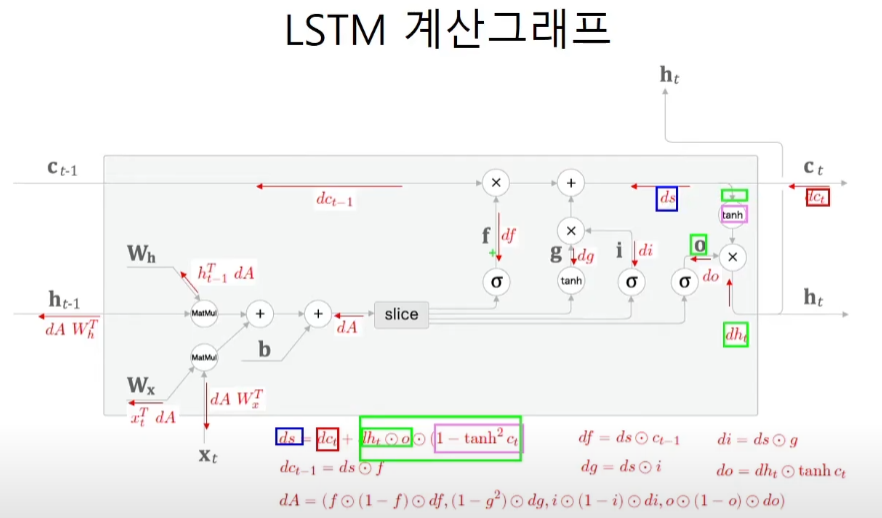

## Q5) Explain why LSTM prevents gradient vanishing problem.

*Your Answer:*

Cell State의 역전파에서는 '+'와 'x' 노드만을 지난다.
- '+' 노드는 상류에서 전해지는 기울기를 그대로 흘리므로, 기울기 변화가 발생하지 않는다.
- 'x' 노드에서는 아다마르 곱(요소별 곱)을 계산한다. RNN의 역전파에서는 똑같은 가중치 행렬을 사용하여 행렬 곱(MatMul)을 반복했고, 이로 인해 기울기 소실 or 폭발이 일어났다. 하지만 LSTM의 역전파에서는 아다마르 곱이 이루어지고, 매 timestep마다 다른 forget gate 값을 이용하므로 곱셈의 효과가 누적되지 않아 기울기 소실이 일어나지 않는다. 이때, forget gate가 잊어야 한다고 판단한 cell state의 원소에 대해서는 기울기가 작아지는 반면, 잊어서는 안 된다고 판단한 원소에 대해서는 기울기가 약화되지 않은 채로 과거 방향으로 전해진다.  

## Q6) Does LSTM still work when the value from a forget gate at time $\tau$ is zero? What is the meaning of this situation?

*Your Answer:*

LSTM에서 시간 τ에서의 forget gate 값이 0일 경우에도 LSTM은 잘 작동한다. forget gate 값이 0이면 이전 cell state의 정보는 현재 시점의 cell state에 영향을 미치지 않는다. 이 상황은 forget gate가 과거의 정보가 중요하지 않아 잊어도 된다고 판단할 때 발생한다. 이를 통해 LSTM은 불필요한 정보를 효과적으로 제거하여 더 중요한 정보에 집중할 수 있다.